# LLM Judges - who watches the watcher?

## Why LLM as a judge


Human evaluation of AI systems is considered the gold standard. If possible, human evaluation should take precedent over Large Language Model (LLM) evaluation.  

However, human evaluation is expensive, time-consuming, and despite being the gold standard, is also not perfect. LLM based evaluation can be used as a supplementary evaluation in coordination with human evaluation, or to replace it if human evaluation is not possible. 

There are traditional automated metrics like BLEU, ROUGE, and METEOR; while computationally efficient and reproducible, they often fail to capture the nuanced qualities that make text truly effective such as coherence, creativity, factual accuracy, and appropriateness to context. 

LLMs operating as judges represent a promising middle ground, offering the potential to combine the scalability of automated metrics with the nuanced understanding traditionally reserved for human evaluators


## When LLM Judges Excel

Multi-Dimensional Evaluation: Most evaluation tasks require assessment across numerous criteria simultaneously. LLM judges can be prompted to consider multiple aspects systematically, providing structured feedback that would be costly and time-consuming to obtain from human evaluators for each dimension.

Subjective Quality Assessment: Traditional NLP metrics struggle with inherently subjective qualities like humour or persuasiveness. LLM judges, trained on vast amounts of human-generated text and feedback, can approximate human judgments on these subjective dimensions with reasonable accuracy, particularly when provided with clear evaluation criteria and examples.

Comparative Evaluation: When the goal is to rank or compare multiple outputs rather than assign absolute scores, LLM judges excel at pairwise comparisons. Research has shown that LLM judges often demonstrate higher agreement with human preferences in head-to-head comparisons than in absolute scoring tasks, making them particularly valuable for model comparison and A/B testing scenarios.

Domain-Specific Assessment: In specialized domains where, human experts are scarce or expensive, LLM judges can be fine-tuned or prompted with domain-specific knowledge to provide preliminary assessments. While they may not replace expert human judgment entirely, they can serve as an initial screening mechanism or provide standardized evaluation criteria that experts can then review more efficiently.

Explainability: Unlike traditional NLP metrics, LLM as a judge can ‘explain’ its decision when it gives one. This allows for better error analysis and iterative model improvement. But care must be taken such to not ‘overfit’ a system to a judge’s preferences without careful concern being taken to ensure that the judge aligns with human preferences, a fundamental concern of a later section of this article. 


# On bias in LLM judges

As well as inconsistency, LLM judges can be subject to bias. In the same way human judges are, LLM judges can tend towards favouritism of certain things when measured over several instances. Three biases of LLM judges that have been proven in research are: positional bias, verbosity bias, and self-bias [2]. However, this is not an exhaustive list and careful consideration should be taken to minimise all potential bias. 

<b>Positional bias </b> suggests that if an LLM is fed several choices, then it tends to prefer the first one – however this can be mitigated by shuffling order of responses or sending single responses and asking the LLM judges to score them independently. Sending individually, however, removes the grounding of direct comparison.

<b>Verbosity bias </b> seems extremely prevalent in LLM judges’ decision making. Both [3] and [4] found that LLM judges prefer longer more verbose answers, even when the longer answer has more factual errors than the shorter answer. In short, they tend to favour quantity over quality.

It has also been noted that LLM judges tend to favour work which was produced by the same underlying model as the judge. This is coined as <b>self-bias.</b> [5]


## Minimising LLM judge bias with pre-calibration - Introducing judgesync! 🧑🏼‍⚖️

Ive created a lightweight python package that helps you callibrate LLM judges: https://github.com/jasher4994/judgesync

In [17]:
from judgesync import AlignmentTracker, ScoreRange

In [18]:
# Load your evaluation data
tracker = AlignmentTracker(score_range=ScoreRange.FIVE_POINT)
tracker.load_human_scores_from_csv("sample_data.csv")

# Prompt comparison

In [19]:
prompt_comparison = tracker.create_comparison()

In [20]:
prompt_comparison.add_judge(
    name="lenient",
    system_prompt="You are a generous evaluator. Focus on the positive aspects of responses.",
)

prompt_comparison.add_judge(
    name="balanced",
    system_prompt="You are a balanced evaluator. Consider both strengths and weaknesses fairly.",
)

prompt_comparison.add_judge(
    name="Strict",
    system_prompt="You are a strict evaluator. Only give high scores to great responses.",
)

prompt_comparison.add_judge(
    name="Suyash",
    system_prompt="You are an extremely strict evaluator. Only give high scores to exceptional responses.",
)

prompt_comparison.add_judge(
    name="gpt-4o low temp",
    system_prompt="You are an extremely strict evaluator. Only give high scores to exceptional responses.",
    deployment_name="gpt-4o",
    temperature=0.3,
)

prompt_comparison.add_judge(
    name="gpt-4.1 high temp",
    system_prompt="You are an extremely strict evaluator. Only give high scores to exceptional responses.",
    deployment_name="gpt-4.1",
    temperature=0.9,
)

prompt_comparison.add_judge(
    name="Tailored",
    system_prompt="""You are evaluating response quality on a 1-5 scale. Base your scoring on these criteria:

SCORE 5 (Excellent - Give sparingly, ~10% of responses):
- Comprehensive, accurate explanation with multiple key points
- Includes specific details, examples, or technical accuracy
- Demonstrates deep understanding of the topic
- Example: "Machine learning is when computers learn patterns from data without being explicitly programmed for every scenario. The system improves through experience. It involves algorithms that can identify patterns and make decisions."

SCORE 4 (Good - ~25% of responses):
- Accurate and mostly complete answer
- Covers main points with good clarity
- May lack some details but fundamentally correct
- Example: "Vaccines train your immune system to recognize and fight specific diseases by introducing a weakened or inactive form of the pathogen."

SCORE 3 (Average - Most common score, ~40% of responses):
- Basic correct answer that addresses the question
- Simple but accurate explanation
- Lacks depth but shows understanding
- Example: "Weather is what's happening outside right now. Climate is the average weather over many years."

SCORE 2 (Below Average - ~20% of responses):
- Overly simplified or incomplete
- Technically not wrong but missing important context
- Too brief to be useful
- Example: "Plants make food from sunlight, that's basically it."

SCORE 1 (Poor - Rarely use, ~5% of responses):
- Incorrect, misleading, or completely inadequate
- Fails to answer the question meaningfully

CRITICAL INSTRUCTIONS:
1. Most responses should score 3 (average) - this is the default for basic correct answers
2. Brief answers can still score 3 if they're accurate
3. Don't confuse brevity with poor quality - evaluate accuracy first
4. Reserve score 5 for truly comprehensive responses
5. Score 2 is for answers that are too simple to be useful, not just brief

When in doubt between scores, choose the lower one - be conservative with high scores.""",
    deployment_name="gpt-4.1",
    temperature=0.1,
)

#Prompts are appended with text relative to the point scale chosen.

Cohen's Kappa measures agreement between two raters (in your case, humans vs LLM judge) while accounting for agreement that would happen by random chance.

κ = (Observed Agreement - Chance Agreement) / (1 - Chance Agreement)

κ = 0.7: Your judge is production-ready
κ = 0.5: Decent, but tune your prompts
κ = 0.3: Needs significant improvement
κ = 0.0: No better than random scoring

Agreement Rate = (Number of Exact Matches) / (Total Number of Items) × 100%

In [21]:
prompt_results = prompt_comparison.run_comparison(
    tracker.data_loader.items, use_async=True
)
print(prompt_results)

JUDGE COMPARISON RESULTS

Rankings by Kappa Score:
  1. Tailored: κ=0.404, Agreement=66.0%, Correlation=0.704
  2. Strict: κ=0.184, Agreement=42.0%, Correlation=0.409
  3. gpt-4o low temp: κ=0.155, Agreement=40.0%, Correlation=0.459
  4. Suyash: κ=0.109, Agreement=46.0%, Correlation=0.317
  5. gpt-4.1 high temp: κ=0.094, Agreement=42.0%, Correlation=0.413
  6. balanced: κ=0.044, Agreement=32.0%, Correlation=0.468
  7. lenient: κ=-0.003, Agreement=8.0%, Correlation=0.201

🏆 Best Judge: Tailored


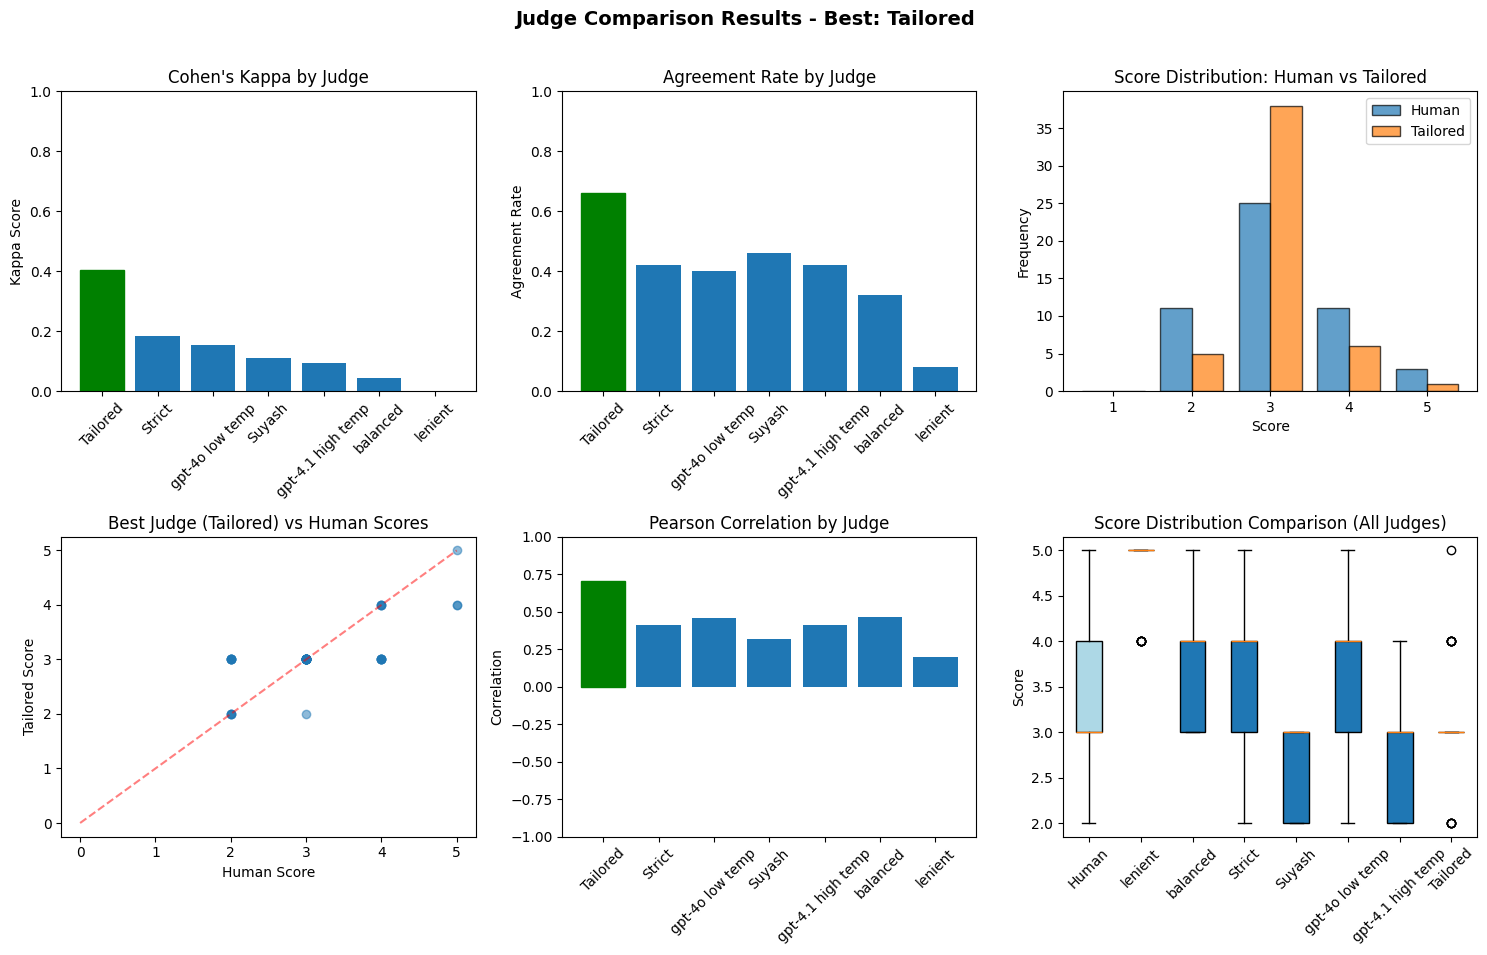

In [22]:
prompt_comparison.plot_comparison(
    prompt_results, save_path="prompt_comparison.png", show=True
)

In [23]:
disagreements = prompt_comparison.get_disagreement_items(prompt_results, threshold=1.0)
print(f"\nFound {len(disagreements)} items with high disagreement between prompts")


Found 11 items with high disagreement between prompts


In [24]:
print(disagreements)

    human_score  lenient  balanced  Strict  Suyash  gpt-4o low temp  \
2           4.0      5.0       4.0     4.0     2.0              3.0   
8           3.0      5.0       3.0     3.0     2.0              4.0   
11          3.0      5.0       4.0     3.0     2.0              3.0   
14          2.0      5.0       3.0     2.0     2.0              2.0   
16          3.0      5.0       4.0     5.0     3.0              5.0   
21          3.0      5.0       4.0     3.0     2.0              3.0   
25          2.0      5.0       3.0     3.0     2.0              3.0   
31          2.0      5.0       3.0     3.0     2.0              3.0   
37          3.0      5.0       4.0     4.0     2.0              3.0   
41          3.0      5.0       3.0     3.0     2.0              3.0   
49          3.0      5.0       4.0     3.0     2.0              3.0   

    gpt-4.1 high temp  Tailored  
2                 2.0       3.0  
8                 2.0       3.0  
11                2.0       3.0  
14         